<a href="https://colab.research.google.com/github/rakhimovv/cv-course-hse-spring20/blob/master/03-edgescorners/corners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Harris corner detection

In [ ]:
#!pip install imageio
#!pip install utils
#!pip install conv
#!pip install scikit-image

In [2]:
from imageio import imread, imsave
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from skimage import io
import numpy as np
import conv

In [3]:
image = imread('./spine.png').astype(float)

In [4]:
def show(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')

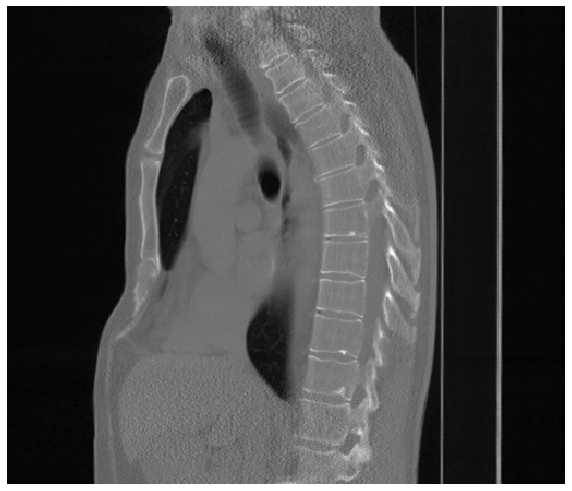

In [5]:
show(image)

### Градиент

In [6]:
gx, gy = np.gradient(image)

In [7]:
gxx = gx ** 2
gyy = gy ** 2
gxy = gx * gy

### Матрица М

In [8]:
import scipy
from scipy import stats

def get_gaussian_kernel(size=17, nsig=3):
    x = np.linspace(-nsig, nsig, size + 1)
    kernel_1D = np.diff(stats.norm.cdf(x))
    
    kernel_2D = np.outer(kernel_1D, kernel_1D)
    kernel_2D_norm = kernel_2D / kernel_2D.sum()
    
    return kernel_2D_norm

In [9]:
kernel = get_gaussian_kernel()

In [10]:
from scipy.signal import convolve2d

In [11]:
mxx, myy, mxy = [convolve2d(x, kernel, mode='same') for x in [gxx, gyy, gxy]]

### Theta (corner response function)

In [12]:
alpha = 0.05
theta = (
    mxx * myy - mxy ** 2 # det
    - alpha *
    (mxx + myy) ** 2 # trace
)

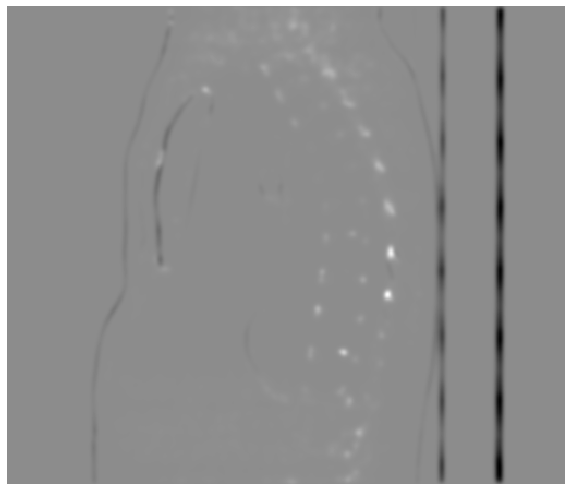

In [13]:
show(theta)

### Пороговое значение, поиск локальных максимумов

In [14]:
thresholded = theta > 5000

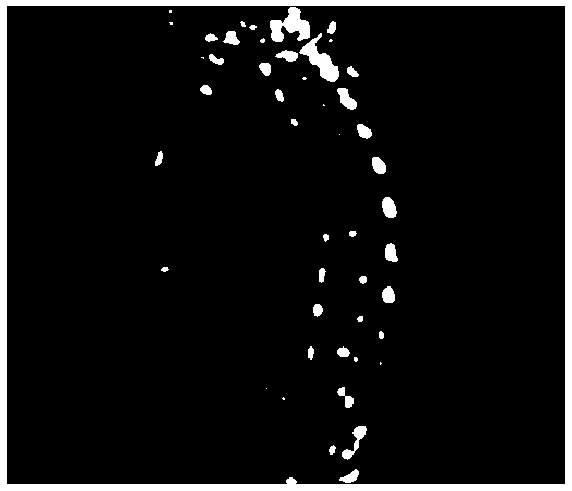

In [15]:
show(thresholded)

In [16]:
from skimage.measure import label

In [17]:
components = label(thresholded)

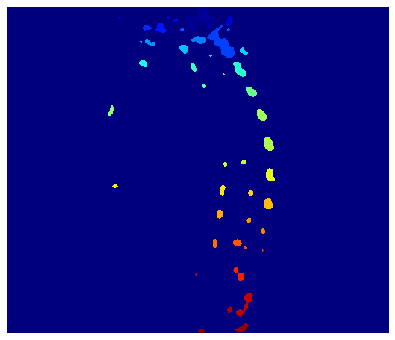

In [18]:
plt.figure(figsize=(10,6))
plt.imshow(components, cmap='jet')
plt.axis('off');

In [19]:
labels = np.unique(components)
labels = labels[1:] # drop the background

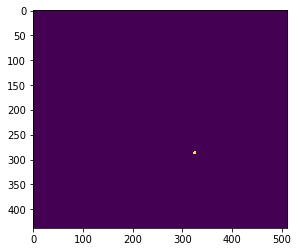

In [32]:
component = 36
comp_mask = components == component
plt.imshow(comp_mask)

In [21]:
indices = []

for component in labels:
    comp_mask = components == component
    
    idx = np.argmax(theta * comp_mask)
    
    # argmax returns a flat index, so make id 2D:
    idx = np.unravel_index(idx, theta.shape)
    indices.append(idx)
    
indices = np.array(indices)

ys, xs = indices.T

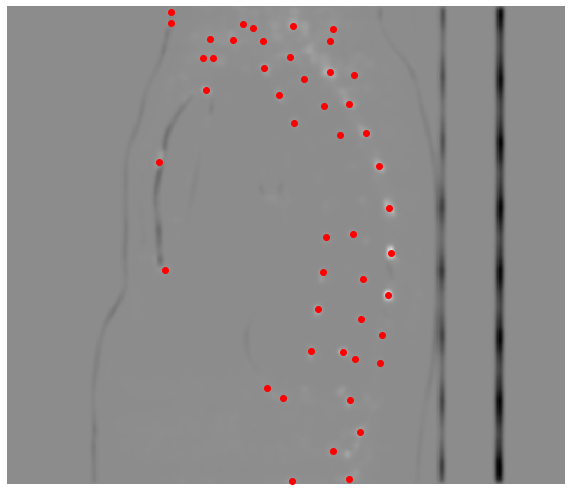

In [22]:
show(theta)
plt.scatter(xs, ys, c='r')

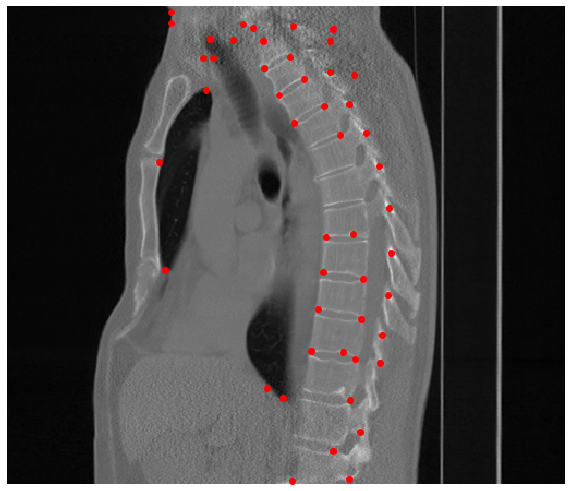

In [23]:
show(image)
plt.scatter(xs, ys, c='r')

## Матрица признаков ключевых точек изображения

In [24]:
gx, gy = np.gradient(image)
magnitude = np.sqrt(gx ** 2 + gy ** 2)
angle = np.arctan2(gy, gx)
angle[angle < 0] += np.pi

In [35]:
size=7
ind = indices[1]
local_gx = gx[ind[0]-size: ind[0]+size+1, ind[1]-size: ind[1]+size+1]
local_gy = gy[ind[0]-size: ind[0]+size+1, ind[1]-size: ind[1]+size+1]

local_magnitude = np.sqrt(local_gx ** 2 + local_gy ** 2)
local_angle = np.arctan2(local_gy, local_gx)
local_angle[local_angle < 0] += np.pi

hog, _ = np.histogram(local_angle, bins=BINS, weights=local_magnitude, density=False)

In [55]:
BINS = 16
def compute_hog(image, ind, size=7, bins=BINS):
    
    low_x = min(0, ind[0]-size)
    high_x = max(ind[0]+size+1, image.shape[0])
    low_y = min(0, ind[1]-size)
    high_y = max(ind[1]+size+1, image.shape[1])
    local_gx = gx[low_x: high_x, low_y: high_y]
    local_gy = gy[low_x: high_x, low_y: high_y]
    
    local_magnitude = np.sqrt(local_gx ** 2 + local_gy ** 2)
    local_angle = np.arctan2(local_gy, local_gx)
    local_angle[local_angle < 0] += np.pi
    
    hog, _ = np.histogram(local_angle, bins=bins, weights=local_magnitude, density=True)
    return hog

In [56]:
number_of_kp = len(indices)
feature_matrix = np.zeros((number_of_kp, BINS))

for i in range(number_of_kp):
    feature_matrix[i] = compute_hog(image, indices[i])
    

# Собираем все вместе

In [50]:
def harris_theta(image, alpha=0.05, kernel_size=17):
    gx, gy = np.gradient(image)
    
    # outer product elements
    gxx = gx ** 2
    gyy = gy ** 2
    gxy = gx * gy
    
    kernel = get_gaussian_kernel(kernel_size)
    
    # matrix M components
    mxx, myy, mxy = [convolve2d(x, kernel, mode='same') for x in [gxx, gyy, gxy]]
    
    theta = (
        mxx * myy - mxy ** 2 # det
        - alpha *
        (mxx + myy) ** 2 # trace
    )
    
    return theta


def get_corners_indices(theta, threshold):
    components = label(theta > threshold)
    labels = np.unique(components)
    labels = labels[1:] # drop the background
    
    indices = []
    for component in labels:
        comp_mask = components == component

        idx = np.argmax(theta * comp_mask)

        # argmax returns a flat index, so make id 2D:
        idx = np.unravel_index(idx, theta.shape)
        indices.append(idx)

    indices = np.array(indices)

    ys, xs = indices.T
    return ys, xs

# Проверяем на инвариантность

In [51]:
translated = image[30:, 50:] # simplest translation

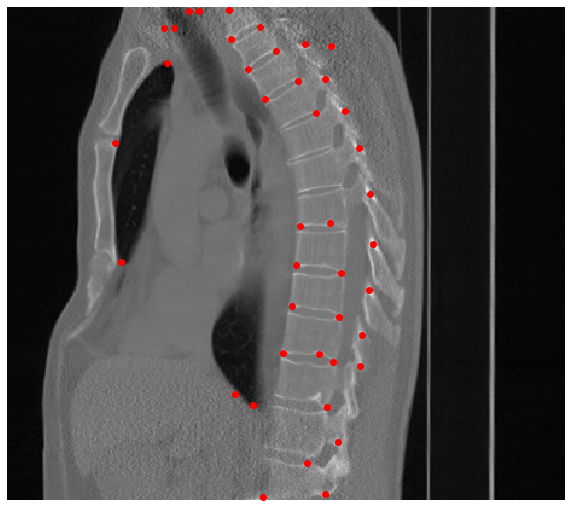

In [54]:
theta = harris_theta(translated)
th = 5000
ys, xs = get_corners_indices(theta, th)
show(translated)
plt.scatter(xs, ys, c='r')

## Поворот

In [53]:
from skimage.transform import rotate

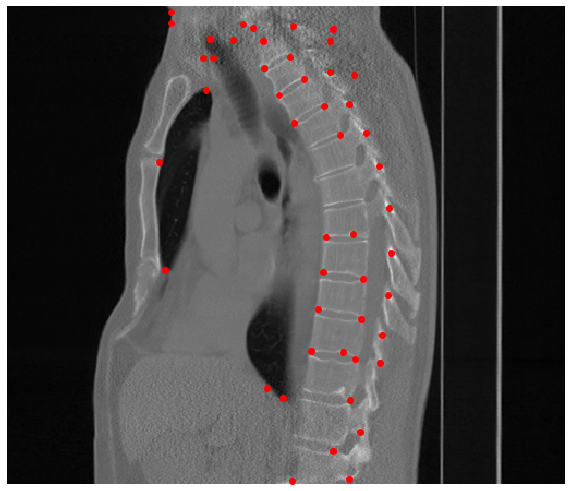

In [59]:
theta = harris_theta(image)
th = 5000
ys, xs = get_corners_indices(theta, th)
show(image)
plt.scatter(xs, ys, c='r')

In [60]:
rotated = rotate(image, 25)

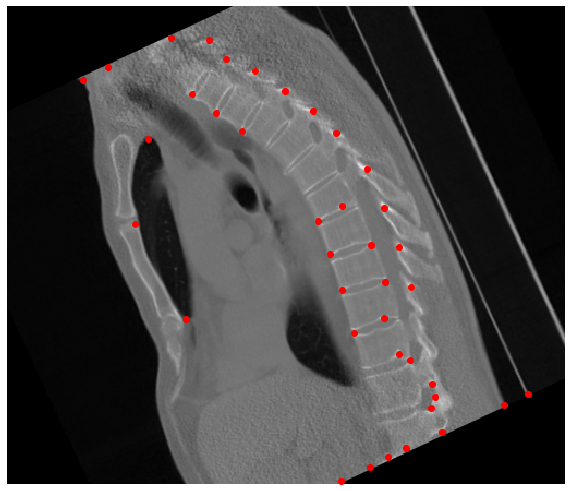

In [61]:
theta = harris_theta(rotated)
th = 5000
ys, xs = get_corners_indices(theta, th)
show(rotated)
plt.scatter(xs, ys, c='r')

Соответствие вполне сносное, хотя нектороые точки пропали. Почему так? Разве детектор Харриса не инвариантен к поворотам?

## Масштабирование

In [65]:
image.shape

(438, 512)

In [62]:
# the simplest scaling there is
scaled = image[::3, ::3]

In [64]:
scaled.shape

(146, 171)

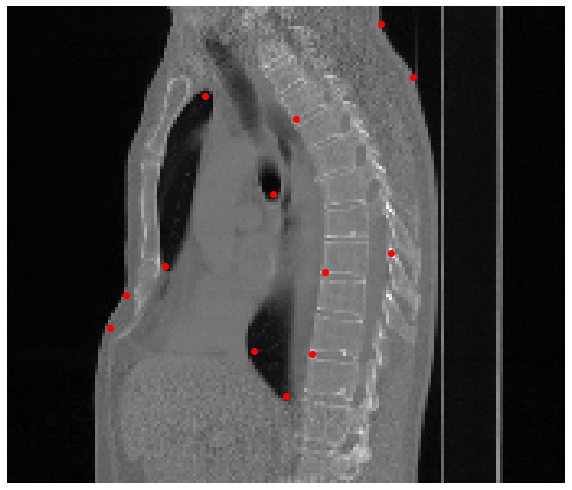

In [73]:
theta = harris_theta(scaled)
th = 5000
ys, xs = get_corners_indices(theta, th)
show(scaled)
plt.scatter(xs, ys, c='r')

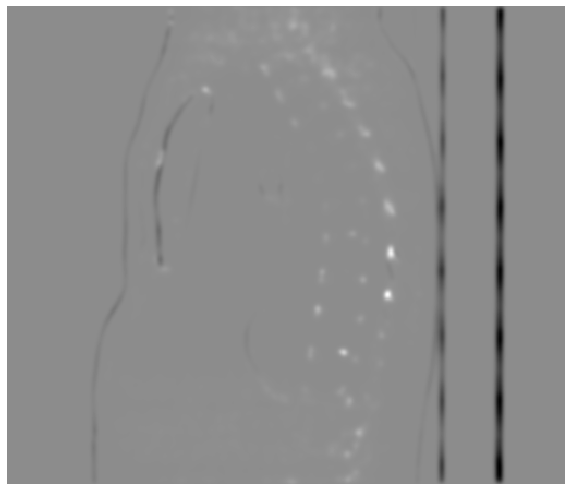

In [71]:
show(harris_theta(image))

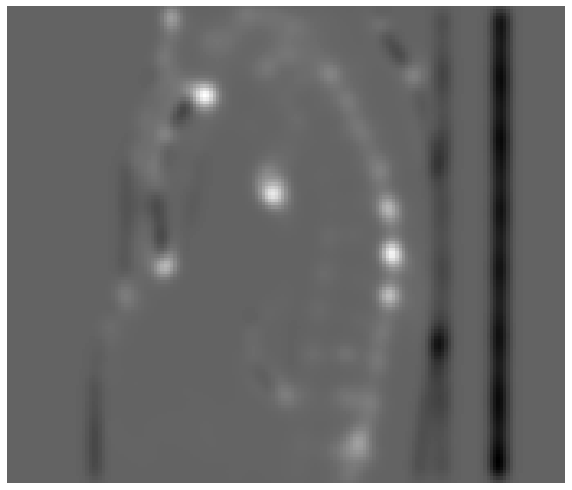

In [72]:
show(harris_theta(scaled))

Некоторые границы просто исчезли, поскольку фильтр Гаусса слишком большой для подобного масштаба.